# Scaffold hopping by holistic molecular representation in drug design

#### Francesca Grisoni,* Gisbert Schneider
#### parallelized code and vectorized function (numpy 3.9) Guillaume Godin

ETH Zurich, Department of Chemistry and Applied Biosciences, RETHINK, Vladimir-Prelog-Weg 4, 8093, Zurich, Switzerland. <div>
*Corresponding author: francesca.grisoni@pharma.ethz.ch 


## Table of Contents
1. [Preliminary steps](#preliminary)
2. [Molecule import and pre-treatment](#import)
3. [WHALES descriptors](#whales) <div>
    a. [*WHALES calculation*](#calculation) <div>
    b. [*Descriptor scaling*](#scaling)
4. [Virtual screening](#vs)<div>
    a. [*Similarity calculation*](#similarity)<div>
    b. [*Identification of top hits*](#tophits)<div>
5. [Scaffold analysis](#scaffold)<div>
    a. [*Template scaffold*](#templatescaffold)<div>
    b. [*Library scaffold diversity*](#libraryscaffold)<div>
    c. [*Scaffold diversity of the top hits*](#tophitsscaffold)<div>
6. [How to cite](#cite) 

# Import of necessary packages <a name="preliminary"></a>

Here you will find all of the necessary packages that will be used in this Jupyter Notebook. No worries, they should all be installed already in your virtual environment!

In [1]:
# chemistry toolkits
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw # for molecule depiction
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Scaffolds import MurckoScaffold
# WHALES-related code
import ChemTools as tools # for molecule pretreatment
import do_whales # importing WHALES descriptors
from ChemTools import prepare_mol_from_sdf # to pretreat the virtual screening library
# for data analysis and plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
 
from joblib import Parallel, delayed
import pandas as pd

# to delete before uploading
%load_ext autoreload
%autoreload
%reload_ext ChemTools
%reload_ext do_whales

# Molecule import and pre-treatment <a name="import"></a>

## Template molecule

Import and visualization of galantamine, starting from SMILES

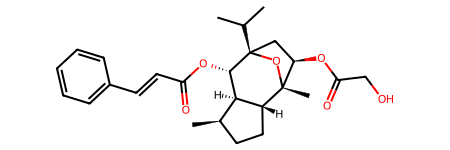

In [2]:
# import template from SMILES
template = Chem.MolFromSmiles('C[C@@H]1CC[C@@H]2[C@@H]1[C@@H]([C@@]3(C[C@H]([C@]2(O3)C)OC(=O)CO)C(C)C)OC(=O)/C=C/c4ccccc4') # imports from SMILES
# add 2D coordinates for visualization
err = AllChem.Compute2DCoords(template)
template

Prepare the molecule, by checking for errors and optimizing the 3D conformation

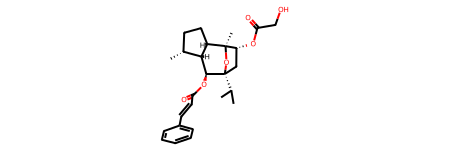

In [3]:
mol, err = tools.prepare_mol(template)
mol

Inspect the partial charges that will be used for WHALES calculation

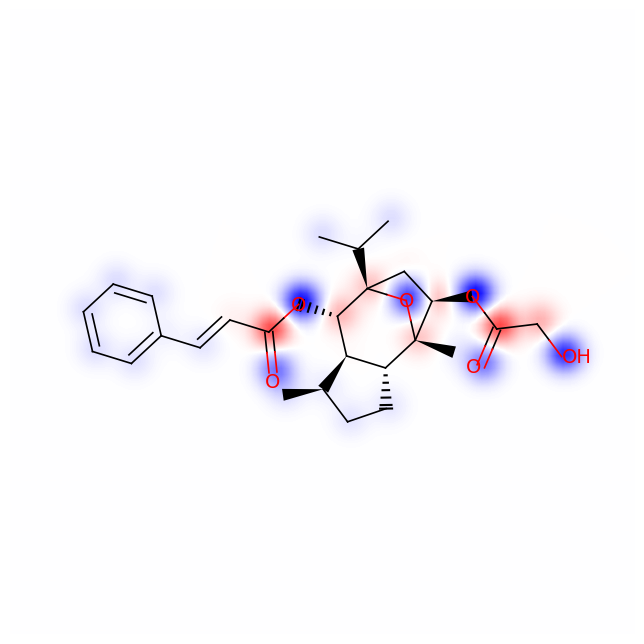

In [4]:
tools.do_map(template,lab_atom=True)

In [5]:
whales_template, lab = do_whales.whales_from_mol(template)


In [6]:
writer = Chem.rdmolfiles.SDWriter('out.sdf')
writer.write(mol)

## Compound library

Import and prepare library

In [7]:
# set the path to the sdf file for input and output
input_filename = '../data/library.sdf'
vs_library_2D = Chem.SDMolSupplier(input_filename) # conserved for 2D representations
vs_library = prepare_mol_from_sdf(input_filename) # computes 3D geometry from a specified sdf file

Visually inspect the database after geometry optimization

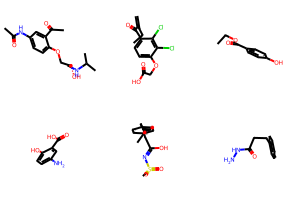

In [8]:
#Visualize the first 6 molecules of the database after geometry optimization
number_mol = 6 # number of molecules to inspect
Draw.MolsToGridImage(vs_library[:number_mol],molsPerRow=3,subImgSize=(100,100))

# WHALES descriptors <a name="whales"></a>

## Descriptors calculation <a name="calculation"></a>

Compute WHALES descriptors for the template molecule

In [9]:
# compute descriptors as an array
whales_template, lab = do_whales.whales_from_mol(template)
# convert the arrays into a pandas dataframe
df_whales_template = pd.DataFrame(whales_template.reshape(-1, len(whales_template)),index=['template'],columns=lab)
df_whales_template

,R_0,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,...,IR_1,IR_2,IR_3,IR_4,IR_5,IR_6,IR_7,IR_8,IR_9,IR_10
template,-2.202,-0.097,-0.101,-1.59,-0.057,-0.088,-1.413,-0.043,-0.054,-1.17,...,0.018,0.392,0.042,0.059,0.481,0.055,0.147,0.784,0.062,0.226


In [10]:
%load_ext line_profiler


In [11]:
import cProfile

# Define your function
def your_function():
    do_whales.whales_from_mol(template)

# Run the profiler
profiler = cProfile.Profile()
profiler.enable()

# Call your function
your_function()

profiler.disable()
profiler.print_stats()

         2598 function calls (2455 primitive calls) in 0.003 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.003    0.003 2758356731.py:12(<module>)
        1    0.000    0.000    0.000    0.000 2758356731.py:14(<module>)
        1    0.000    0.000    0.003    0.003 2758356731.py:4(your_function)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(all)
       32    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(amax)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(any)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(around)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(atleast_1d)
        2    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(concatenate)
        2    0.000    0.000    0.000    0.000 <__array_function__ inte

In [12]:
%lprun -f your_function your_function()


Timer unit: 1e-09 s

Total time: 0.002203 s
File: /var/folders/4w/xmf8nmhs51j4vjsttzcxmmm00000gn/T/ipykernel_1543/2758356731.py
Function: your_function at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def your_function():
     5         1    2203000.0 2203000.0    100.0      do_whales.whales_from_mol(template)

In [13]:
%timeit do_whales.whales_from_mol(template)


919 µs ± 8.01 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Compute WHALES for the virtual screening library

In [14]:


def process_mol(mol):
    whales_temp, _ = do_whales.whales_from_mol(mol)
    return whales_temp

whales_library = Parallel(n_jobs=-1)(delayed(process_mol)(mol) for mol in vs_library)
df_whales_library = pd.DataFrame(whales_library, columns=lab)
df_whales_library.head()

,R_0,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,...,IR_1,IR_2,IR_3,IR_4,IR_5,IR_6,IR_7,IR_8,IR_9,IR_10
0,-3.870,-0.304,-0.193,-1.559,-0.220,-0.171,-1.263,-0.088,-0.146,-0.987,...,0.061,0.871,0.067,0.090,1.185,0.078,0.158,1.940,0.087,0.182
1,-5.197,-0.297,-0.234,-2.547,-0.251,-0.172,-1.766,-0.188,-0.145,-1.326,...,0.114,0.612,0.107,0.201,0.734,0.135,0.290,0.788,0.285,0.521
2,-21.571,-0.366,-0.132,-1.253,-0.161,-0.120,-1.016,-0.091,-0.099,-0.962,...,0.031,0.372,0.055,0.099,0.484,0.073,0.179,1.056,0.110,0.431
3,-1.804,-0.634,-0.472,-1.409,-0.501,-0.351,-1.120,-0.259,-0.287,-1.075,...,0.045,0.513,0.218,0.458,0.567,0.259,0.471,4.151,0.318,0.621
4,-3.060,-0.493,-0.451,-2.078,-0.387,-0.407,-1.765,-0.199,-0.195,-1.497,...,-0.039,-0.188,0.033,0.037,0.744,0.190,0.172,1.623,0.327,0.814


## Descriptors scaling <a name="scaling"></a>

### Data visualization
Visualizing the raw descriptor values for the virtual screening library using a boxplot

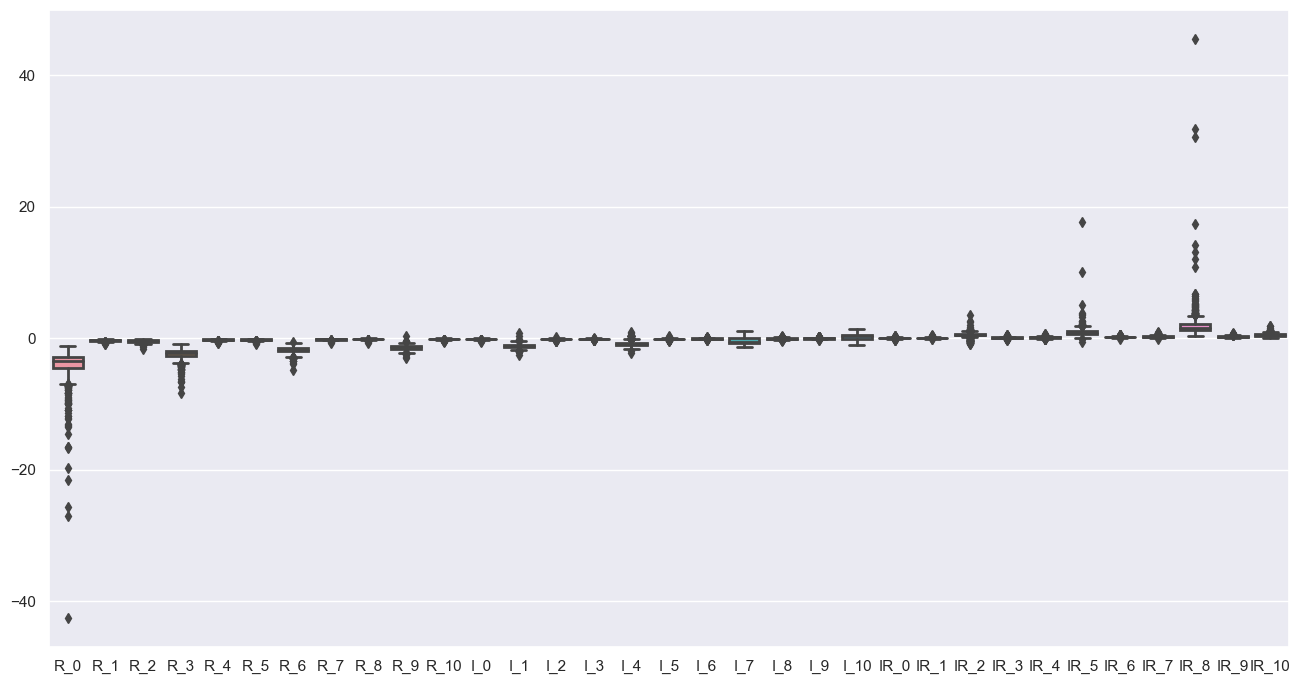

In [15]:
sns.set(rc={'figure.figsize':(16,8.27)}) # sets the size of the boxplot
sns.boxplot(data=df_whales_library,linewidth=2);

### Autoscaling

Virtual library scaling

In [16]:
aver = df_whales_library.mean()
sdv = df_whales_library.std()
df_whales_library_scaled = (df_whales_library - aver)/sdv
df_whales_library_scaled.to_csv('WHALES_after.csv')

Template scaling

In [17]:
df_whales_template_scaled = (df_whales_template - aver)/sdv
df_whales_template_scaled

,R_0,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_9,...,IR_1,IR_2,IR_3,IR_4,IR_5,IR_6,IR_7,IR_8,IR_9,IR_10
template,0.712532,2.18542,1.691389,1.060492,1.902448,1.394435,0.816182,1.754441,1.395606,0.713269,...,-0.575221,-0.5394,-1.014249,-1.076885,-0.651868,-1.49722,-1.097142,-0.496984,-1.865269,-1.271306


### Data visualization
Visualizing the descriptor values for the virtual screening library after autoscaling


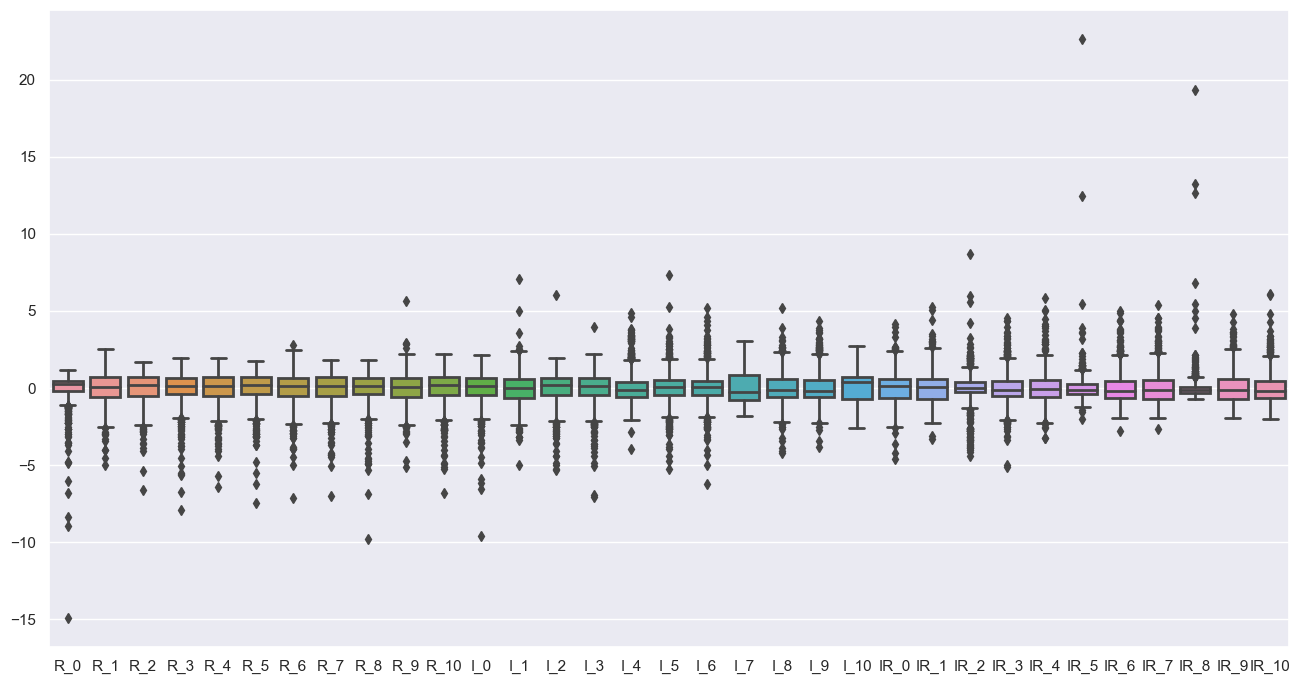

In [18]:
sns.set(rc={'figure.figsize':(16,8.27)})
sns.boxplot(data=df_whales_library_scaled,linewidth=2);

# Virtual screening <a name="vs"></a>

## Similarity calculation <a name="similarity"></a>

In [19]:
# compute Euclidean distance
D = euclidean_distances(df_whales_template_scaled,df_whales_library_scaled)

## Identification of top hits <a name="tophits"></a>
Selection of the 10 closest compounds based on the computed distance on WHALES

In [20]:
# sorting based on distance
sort_index = np.argsort(D) # index for sorting according to D
D_neig = D[:,sort_index] # sorted distance

In [21]:
# selection of the 10 closest compounds
k = 10 # number of compounds to choose
neighbor_ID = sort_index[:,0:k]
neighbor_ID

array([[141, 940, 710, 869, 136, 119, 569, 116, 608,  87]])

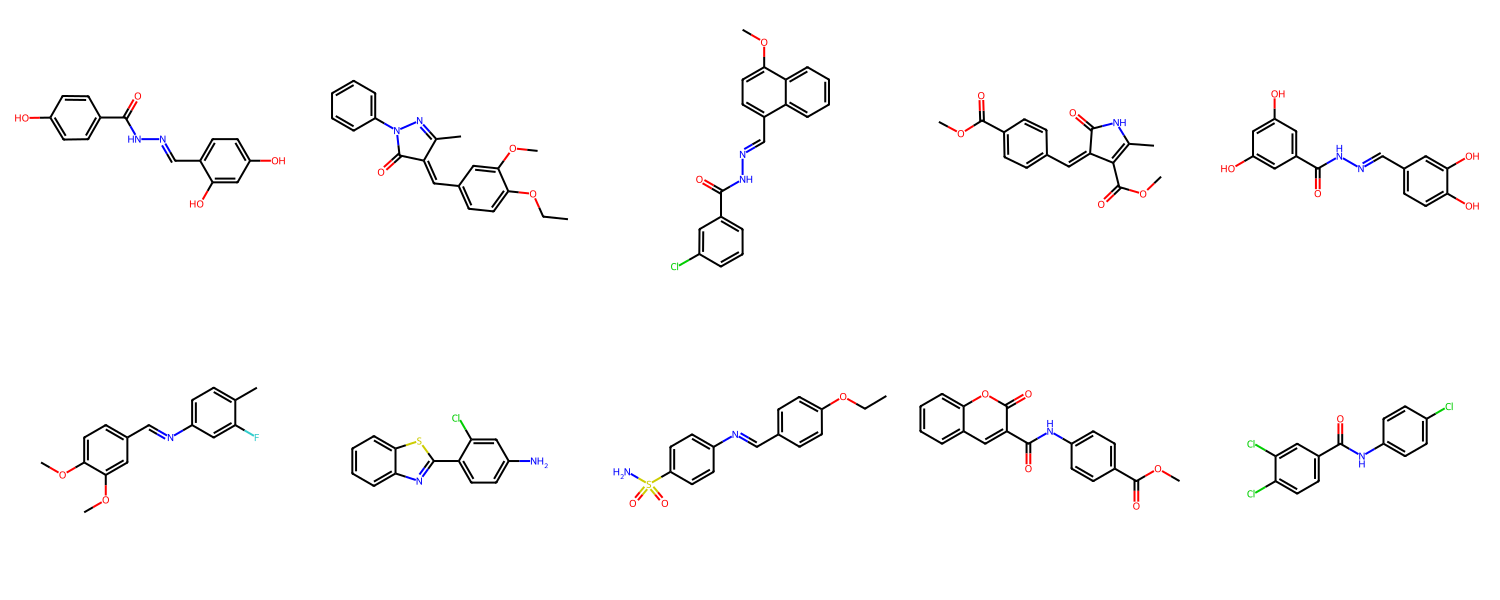

In [22]:
# display of the 10 closest compounds
hits = []
smiles_hits = []
for j in np.nditer(neighbor_ID):
    hits.append(vs_library_2D[int(j)])
    smiles_hits.append(Chem.MolToSmiles(mol))

#Visualize the first 10 molecules of the database after geometry optimization
number_mol = 10 # number of molecules to inspect
Draw.MolsToGridImage(hits[:number_mol+1],molsPerRow=5,subImgSize=(300,300),legends=[x.GetProp("_Name") for x in hits[:number_mol+1]])

# Scaffold analysis <a name="scaffold"></a>

## Template scaffold <a name="templatescaffold"></a>

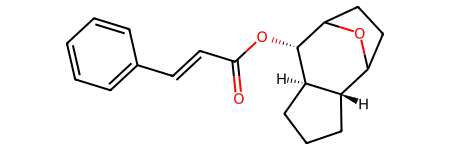

In [23]:
core = MurckoScaffold.GetScaffoldForMol(template)
core

## Scaffold diversity of the virtual screening library

Compute the Bemis-Murcko scaffolds for the virtual screening library

In [24]:
scaffold_vs = [] # generates an empty supplier to contain the computed scaffold
for mol in vs_library_2D:
    scaffold_vs.append(MurckoScaffold.GetScaffoldForMol(mol))

Preview of the scaffolds (4 for display)

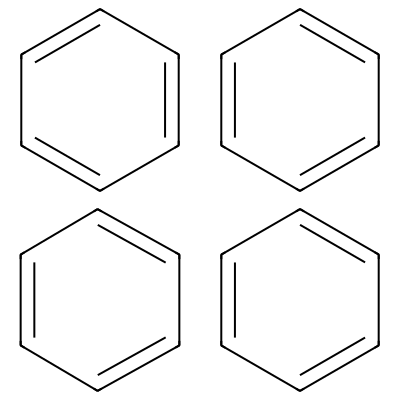

In [25]:
# 4 scaffolds are displayed
k = 4
Draw.MolsToGridImage(scaffold_vs[:k],molsPerRow=2,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in scaffold_vs[:k]])

Most frequently recurring scaffolds in the virtual screening library

In [26]:
freq_scaffolds_library = tools.frequent_scaffolds(vs_library_2D) # contains the list of the (unique) scaffolds, sorted by number

Display the four most occurring scaffolds

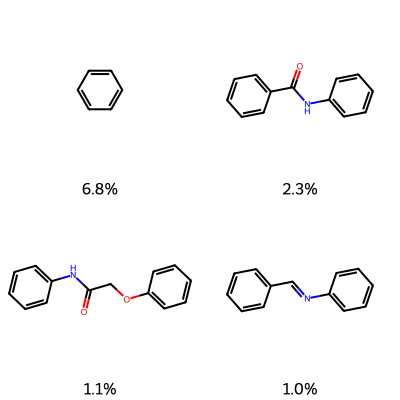

In [27]:
k = 4
Draw.MolsToGridImage(freq_scaffolds_library[:k],molsPerRow=2,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in freq_scaffolds_library[:k]])

Computes the relative scaffold diversity of the library

In [28]:
SD_rel = len(freq_scaffolds_library)/len(vs_library)*100
print(SD_rel)

54.2


## Top hits scaffolds

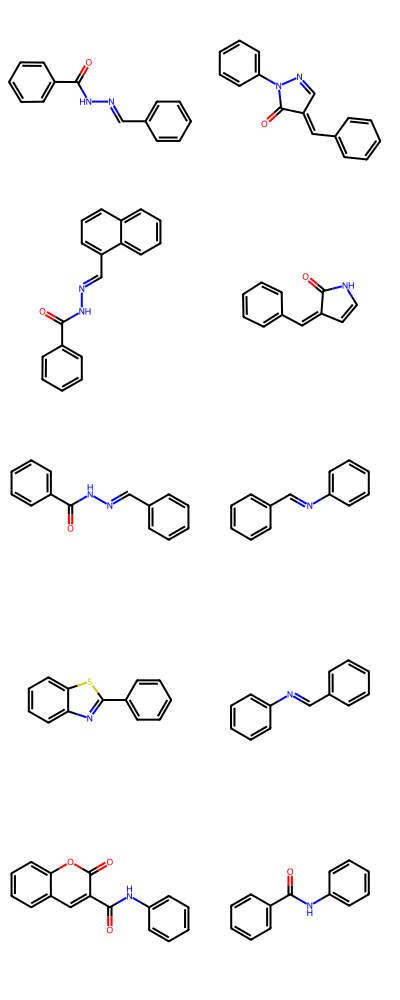

In [29]:
scaffold_hits = []
for mol in hits:
    scaffold_hits.append(MurckoScaffold.GetScaffoldForMol(mol))
 
Draw.MolsToGridImage(scaffold_hits[:10],molsPerRow=2,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in scaffold_hits[:10]])

Computes the frequent scaffolds and the scaffold diversity

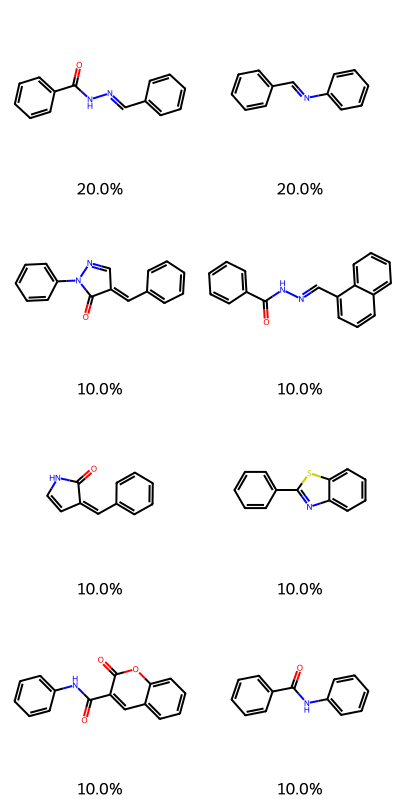

In [30]:
freq_scaffolds_hits = tools.frequent_scaffolds(hits) # contains the list of the (unique) scaffolds, sorted by number
k = len(freq_scaffolds_hits) # display all scaffolds
Draw.MolsToGridImage(freq_scaffolds_hits[:k],molsPerRow=2,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in freq_scaffolds_hits[:k]])

In [31]:
SD_rel = len(freq_scaffolds_hits)/len(hits)*100
print(SD_rel)

80.0


In [32]:
import lcm
import numpy as np

In [33]:
!python lcm.py